In [1]:
import torch
import torch.optim as optim
from torchvision import transforms

import matplotlib.pyplot as plt
from network import StyleTransfer
from utils import load_image, im_convert, gram_matrix

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vgg19 = StyleTransfer().to(device).eval()
vgg19.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# load in content and style image
content = load_image('images/fireworks.jpg', shape=1080).to(device)
# Resize style to match content
style = load_image('images/starry_night_over_the_rhone.jpg', shape=content.shape[-2:]).to(device)

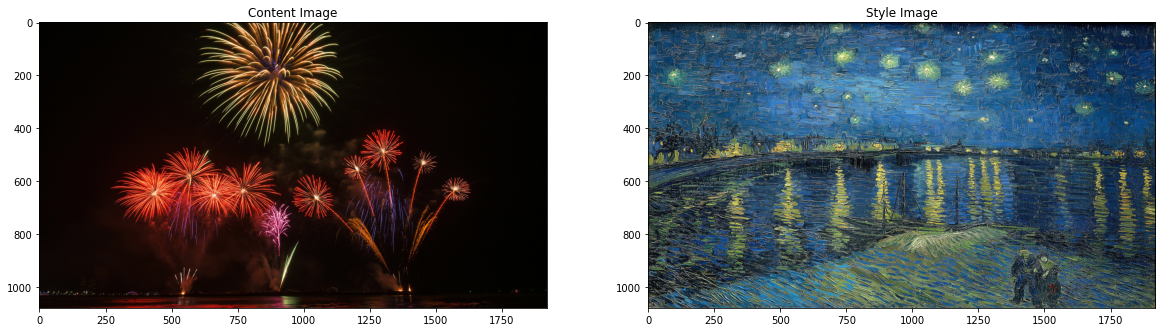

In [5]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(style))
ax2.set_title("Style Image")
plt.show()
fig.savefig('images/content_style_1080p.png', bbox_align='tight')
plt.close()

In [6]:
# get content and style features only once before training
content_features = vgg19(content)
style_features = vgg19(style)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

In [7]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
style_weights = {'relu1_1': 1.,
                 'relu2_1': 0.75,
                 'relu3_1': 0.2,
                 'relu4_1': 0.2,
                 'relu5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e7  # beta

Total loss:  5319056.0


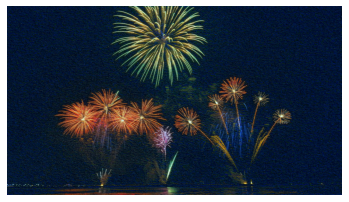

Total loss:  3212004.5


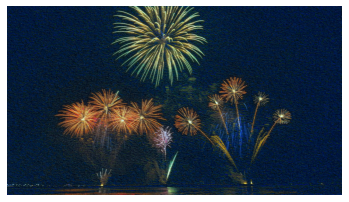

Total loss:  1981851.0


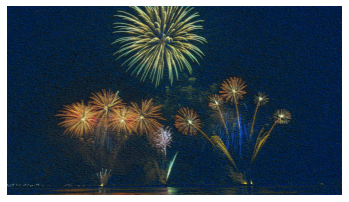

Total loss:  1212906.0


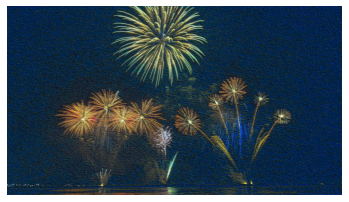

Total loss:  741001.25


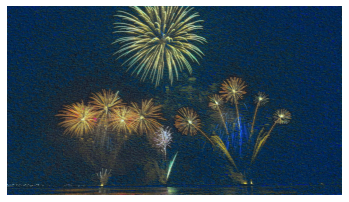

In [8]:
# for displaying and saving the target image, every 400 steps
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 2000  # decide how many iterations to update your image

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = vgg19(target)
    
    # the content loss
    content_loss = torch.mean((target_features['relu4_2'] - content_features['relu4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display and save intermediate images, and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.axis('off')
        plt.imshow(im_convert(target))
        plt.savefig(f'images/1080p-{ii}.png', dpi=300, orientation='landscape', bbox_inches='tight', transparent=True, pad_inches=0)
        plt.show()
        plt.close()

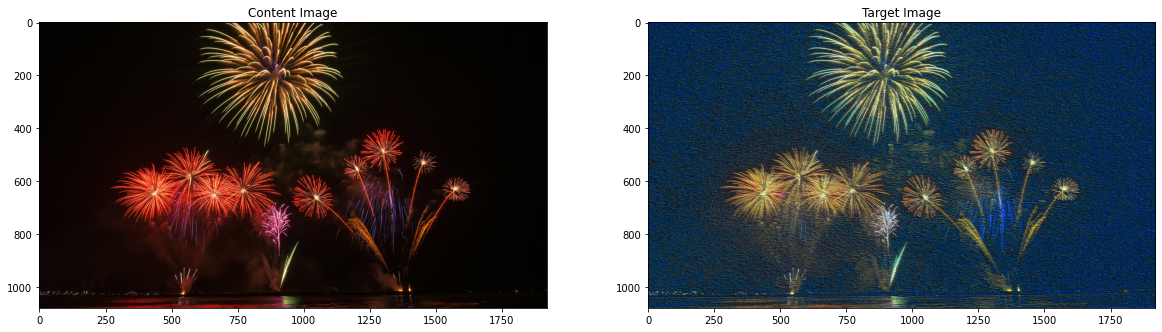

In [9]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image")
ax2.imshow(im_convert(target))
ax2.set_title("Target Image")
plt.show()
fig.savefig('images/style_transfer_1080p.png', bbox_align='tight')
plt.close()